CNN模型的迁移学习
=
* 很多时候当我们需要训练一个新的图像分类任务， 我们不会完全从一个随机的模型开始训练，而是利用预训练的模型来加速训练的过程。我们经常使用在ImageNet上的预训练模型
* 这是一种transfer learning 的方法，我们常用一下两种方法做迁移学习
 * fine tuning: 从一个预训练模型开始， 我们改变一些模型的架构，然后继续训练整个模型的参数。
 * feature extraction: 我们不再改变预训练模型的参数，而是只更新我们改变过的部分模型参数。我们之所以叫它feature extraction是因为我们把预训练的CNN模型当作一个特征提取模型，利用提取出来的特征来完成我们的训练任务。
 
以下是构建和训练迁移学习模型的基本步骤:
* 初始化预训练模型
* 把最后一层的输出层改编成我们想要分的类别总数
* 定义一个optimizer来更新参数
* 模型训练

In [80]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvion Version: ", torchvision.__version__)

Torchvion Version:  0.2.2


数据
-
我们使用hymenoptera_data数据集
这个数据集包括两类图片， bees ants， 这些数据都被处理成了可以使用ImageFolder 来读取的格式，我们只需要把data_dit设置成数据的根目录，然后把model_name设置成我们想要使用的预训练模型
其他参数有
* num_classes
* batch_size
* num_epochs
* feature_extract 表示训练的时候用fine tuning 还是 feature extraction 方法。 如果feature_extract = False, 整个模型会被同时更新。else， 只有模型的最后一层被更更新。

In [96]:
data_dir = "./hymenoptera_data"

model_name = "resnet"

num_classes = 2

batch_size =64

num_epochs = 10

feature_extract = True

input_size = 224

In [97]:
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"),
                                transforms.Compose([
                                    transforms.RandomResizedCrop(input_size),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                ])
                                
                               )


下面这一段代码简直天秀
-

In [98]:
data_transforms = {
    "train":transforms.Compose([
                                transforms.RandomResizedCrop(input_size),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ]),
    
    
    "val":transforms.Compose([
                                transforms.Resize(input_size),
                                transforms.CenterCrop(input_size),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ]),
}

image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train","val"]}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                   batch_size = batch_size,
                                                   shuffle = True,
                                                   num_workers = 4) for x in ["train", "val"]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [99]:
img = next(iter(dataloaders_dict["val"]))[0]

In [100]:
img.shape

torch.Size([64, 3, 224, 224])

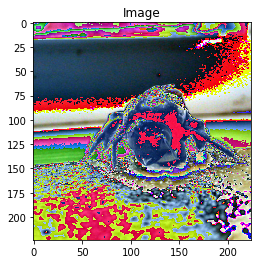

In [101]:
unloader = transforms.ToPILImage() # reconver into PIL image
# .ToPILImage 把tensor或数组转换成图像


plt.ion() # 交互模式
# https://blog.csdn.net/SZuoDao/article/details/52973621
# plt.ioff()

def imshow(tensor, title = None):
    image = tensor.cpu().clone() # clone the tensor to note do changes on it
    image = image.squeeze(0) # remove the fake batch dimension
    image = unloader(image) # tensor 转换成图像
    plt.imshow(image)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001) # 可以去掉，只是延迟显示作用
    
plt.figure()
imshow(img[12], title='Image')

In [102]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
            
            

def initialize_model(model_name, num_classes, feature_extract, use_pretrained = True):
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("model not implemented")
        return None, None
        
    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained = True)

# print(model_ft)

In [103]:
model_ft.fc.weight.requires_grad # 只有最后一层会做更新

True

In [104]:
model_ft.layer1[0].conv1.weight.requires_grad

False

模型训练
-


In [105]:
model_ft = model_ft.to(device)

In [106]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), 
                            lr = 0.001, momentum = 0.9)

loss_fn = nn.CrossEntropyLoss()


In [120]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_acc_history = []
    for epoch in range(num_epochs):
        
        
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) ==labels.view(-1)).item()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            print("Phase {} loss: {}  acc: {}".format(phase, epoch_loss, epoch_acc))
            
            if phase =="val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
        
            
#         plt.plot(val_acc_history)
#         plt.show()
        
    model.load_state_dict(best_model_wts)
    return model, val_acc_history
                

In [121]:
model_ft, hist = train_model(model_ft, dataloaders_dict, loss_fn, optimizer, num_epochs = num_epochs)

Phase train loss: 0.18891272974795983  acc: 0.9426229508196722
Phase val loss: 0.22150270085708768  acc: 0.9281045751633987
Phase train loss: 0.19005064250992948  acc: 0.9549180327868853
Phase val loss: 0.22310670976545297  acc: 0.9281045751633987
Phase train loss: 0.18359853327274323  acc: 0.9426229508196722
Phase val loss: 0.22303856237261904  acc: 0.9281045751633987
Phase train loss: 0.18061947285151872  acc: 0.9385245901639344
Phase val loss: 0.21747888215616637  acc: 0.9281045751633987
Phase train loss: 0.16512758370305672  acc: 0.9631147540983607
Phase val loss: 0.21346122255317526  acc: 0.9281045751633987
Phase train loss: 0.1755758145304977  acc: 0.9385245901639344
Phase val loss: 0.21214539163252888  acc: 0.9281045751633987
Phase train loss: 0.15130190722277906  acc: 0.9836065573770492
Phase val loss: 0.21334117943165348  acc: 0.9281045751633987
Phase train loss: 0.17427441086925444  acc: 0.9385245901639344
Phase val loss: 0.2134841525671529  acc: 0.9281045751633987
Phase trai

In [109]:
hist

[0.43790849673202614,
 0.6209150326797386,
 0.7516339869281046,
 0.8562091503267973,
 0.8758169934640523,
 0.8823529411764706,
 0.8888888888888888,
 0.9019607843137255,
 0.9084967320261438,
 0.9215686274509803]